In [1]:
import os
import torch
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from torch_dataset import BreastCancerDataSet_Basic, BreastCancerDataSet_Mixup
from transforms import DualImageTransformation, get_transforms, DualImageAffineTransformation
import wandb
from training import train_model
import argparse
from models import SimSiam, SimSiamWithAffine
import gc
import numpy as np
from training import extract_model_features


N_FOLDS = 5
IMG_SIZE = (256, 512)
MODEL_TYPE = "resnet18"
DEVICE = "cuda:0"

train_path = "/mnt/striped/CMMD/train.csv"
images_path = "/mnt/striped/CMMD_preprocessed/preprocessed_mp_aspectratio_768_384"

os.environ["NCCL_BUFFSIZE"] = f"{64 * 1024 * 1024}"


In [2]:
import glob
import pandas as pd
df_train = pd.read_csv(train_path, sep=";")
print(df_train.shape[0])
print((df_train.classification == "Malignant").value_counts())
print((df_train.subtype.str.startswith("Luminal") == True).value_counts())
df_train.head()

1872
classification
True     1316
False     556
Name: count, dtype: int64
subtype
False    1344
True      528
Name: count, dtype: int64


,ID1,LeftRight,Age,number,abnormality,classification,subtype
0,D1-0001,R,44,2,calcification,Benign,NaN
1,D1-0002,L,40,2,calcification,Benign,NaN
2,D1-0003,L,39,2,calcification,Benign,NaN
3,D1-0004,L,41,2,calcification,Benign,NaN
4,D1-0005,R,42,2,calcification,Benign,NaN


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
np.max(le.fit_transform(df_train.abnormality))

2

In [4]:
print((df_train.classification == "Malignant").sum() / df_train.shape[0])
print((df_train.subtype.str.startswith("Luminal") == True).sum() / df_train.shape[0])

0.7029914529914529
0.28205128205128205


In [5]:
df_train[df_train.ID1 == 'D1-0012']

,ID1,LeftRight,Age,number,abnormality,classification,subtype
11,D1-0012,L,34,2,calcification,Benign,NaN


In [6]:
"""
from PIL import Image

image_id = df_train.image_id.values[0]

img = Image.open(f'{images_path}/{image_id}.png')
img""";

In [7]:
from models import SimClr

def load_model(model_type, affine, mixup, simclr, checkpoint):
    
    out_dim = 256 if model_type == "resnet18" else 1024

    if affine:
        if mixup:
            raise ValueError("Affine and mixup are not compatible")

        model = SimSiamWithAffine(model_type = model_type, IMG_SIZE = IMG_SIZE)
    else:
        if simclr:
            model = SimClr(model_type = model_type, IMG_SIZE = IMG_SIZE)
        else:
            model = SimSiam(model_type = model_type, IMG_SIZE = IMG_SIZE, out_dim=out_dim)

    model.to(DEVICE)
    #model = DDP(model, device_ids=[DEVICE]) #, broadcast_buffers=False may need to be set in order to prevent hang

    def adjust_key(key : str):
        if key.startswith("module."):
            return key[7:]
        else:
            return key
        
    state_dict = torch.load(checkpoint)
    state_dict = {adjust_key(k):v for k,v in state_dict.items()}
    model.load_state_dict(state_dict)

    return model

In [8]:
gc.collect()

36

In [9]:
def plot_finetunes(series_data, series_labels, y_label, title):
    import matplotlib.pyplot as plt

    x = range(len(series_data[0]))

    for data, label in zip(series_data, series_labels):
        plt.plot(x, data, label=label)

    # Adding title and labels
    plt.ylabel(y_label)
    plt.title(title)

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

Dataset number of images 5590 number of unique patients 1775
cancer value counts cancer
1    4174
0    1416
Name: count, dtype: int64
D1-0051 tensor(1.)


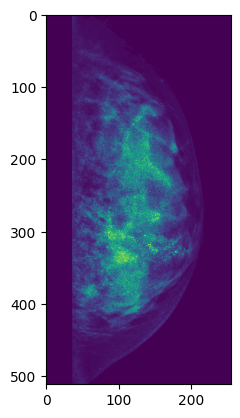

D1-0051 tensor(1.)


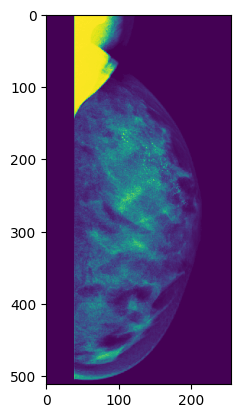

D1-0064 tensor(1.)


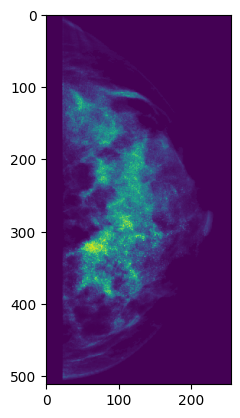

D1-0064 tensor(1.)


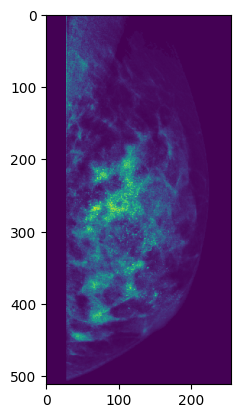

D1-0078 tensor(1.)


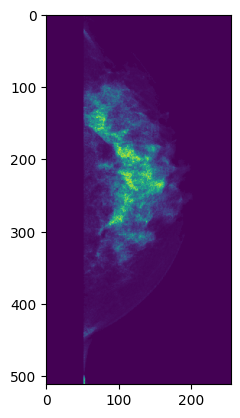

D1-0078 tensor(1.)


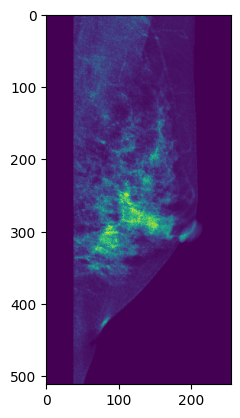

In [10]:
def plot_samples():
    import glob
    df_train = pd.read_csv(train_path, sep=";")
    df_images = pd.DataFrame([(p.split("/")[4], p) for p in glob.glob("/mnt/striped/CMMD/*/*/*/*.dcm")])
    df_images.columns = ["ID1", "path"]
    
    df_train = pd.merge(df_train, df_images, on="ID1", how="left")
    df_train = df_train.reset_index(drop=True)

    df_train["image_id"] = [".".join("/".join(p.split("/")[-2:]).split(".")[:-1]) for p in df_train.path]

    df_train["cancer"] = (df_train["classification"] == "Malignant").astype(int)
    df_train["patient_id"] = df_train.ID1.values
    print("Dataset number of images", df_train.shape[0], "number of unique patients", df_train.patient_id.nunique())

    print("cancer value counts", df_train.cancer.value_counts())

    df_train = df_train.reset_index(drop=True)
    # Set up the folds
    split = StratifiedGroupKFold(N_FOLDS, random_state=42, shuffle=True)
    for k, (_, test_idx) in enumerate(split.split(df_train, df_train.cancer, groups=df_train.patient_id)):
        df_train.loc[test_idx, 'split'] = k
    df_train.split = df_train.split.astype(int)

    ds_eval = BreastCancerDataSet_Basic(df_train.query('split == 0'), 
                                        images_path,
                                        TARGET = 'cancer',
                                        transforms = get_transforms(False, IMG_SIZE),
                                        use_patient_id_for_path=False)

    import matplotlib.pyplot as plt

    n =  5
    i = 0
    for patient_id, (x,y) in zip(df_train.query('split == 0').patient_id, ds_eval):

        if y:
            print(patient_id, y)
            plt.imshow(x[0,:,:])
            plt.show()
            i += 1
        
        if i > n:
            break


plot_samples()

In [11]:
from PIL import Image

class BreastCancerDataSet_MultiLabel(torch.utils.data.Dataset):
    
    def __init__(self, df, path, transforms=None, use_patient_id_for_path = True):
        super().__init__()
        
        self.df = df
        
        self.path = path
        self.transforms = transforms
        self.use_patient_id_for_path = use_patient_id_for_path

        from sklearn.preprocessing import LabelEncoder

        le = LabelEncoder()
        self.one_hot_subtype = torch.as_tensor(le.fit_transform(df.subtype))
        self.one_hot_abnormality = torch.as_tensor(le.fit_transform(df.abnormality))

    def load_image(self, i):
        
        if self.use_patient_id_for_path:
            pth = f'{self.path}/{self.df.iloc[i].patient_id}/{self.df.iloc[i].image_id}.png'
        else:
            pth = f'{self.path}/{self.df.iloc[i].image_id}.png'

        try:
            img = Image.open(pth) #.convert('RGB')
            
        except Exception as ex:
            print(pth, ex)
            return None
        
        return img
            
    def get_labels(self, i):

        label_cancer = torch.as_tensor(self.df.iloc[i].y).float()
        label_subtype = self.one_hot_subtype[i]
        label_abnormality = self.one_hot_abnormality[i]
        
        return label_cancer, label_subtype, label_abnormality

    def __getitem__(self, i):

        img = self.load_image(i)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, self.get_labels(i)

        
    def __len__(self):
        return len(self.df)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn as nn
from timm import create_model

class BinaryClassificationModel(nn.Module):

    def __init__(self, backbone, backbone_dim):
        super(BinaryClassificationModel, self).__init__()
        self.backbone = backbone
        self.backbone_dim = backbone_dim

        # Classification head
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.backbone_dim),
            nn.LeakyReLU(),
            nn.Linear(self.backbone_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

        self.classifier_aux1 = nn.Sequential(
            nn.LeakyReLU(),
            nn.BatchNorm1d(self.backbone_dim),
            nn.LeakyReLU(),
            nn.Linear(self.backbone_dim, 5),
            nn.Softmax(1)
        )
        
        self.classifier_aux2 = nn.Sequential(
            nn.LeakyReLU(),
            nn.BatchNorm1d(self.backbone_dim),
            nn.LeakyReLU(),
            nn.Linear(self.backbone_dim, 3),
            nn.Softmax(1)
        )
    
    def forward(self, x):
        # Get the features from the backbone
        features = self.backbone(x)

        # Classify
        output = self.classifier(features)
        if output.shape[0] > 1:
            output = output.squeeze()
        else:
            output = output.squeeze(0)

        output_aux1 = self.classifier_aux1(features)
        output_aux2 = self.classifier_aux2(features)

        return output, output_aux1, output_aux2
    
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0


from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params

def train_model_simple(model, ds_train, ds_eval,
                batch_size, DEVICE, EPOCHS, sampler = None, 
                shuffle = True, lr = 0.01, pos_weight = None):
    
    num_workers = 6
    
    torch.manual_seed(42)
        
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                           pin_memory=True, pin_memory_device=DEVICE, prefetch_factor=4, sampler=sampler,
                                           drop_last=True)

    dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                                           pin_memory=True, pin_memory_device=DEVICE, prefetch_factor=4, sampler=None,
                                           drop_last=False)

    if pos_weight is not None:
        pos_weight = torch.as_tensor([pos_weight]).to(DEVICE)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    criterion_aux1 = nn.CrossEntropyLoss()
    criterion_aux2 = nn.CrossEntropyLoss()

    count_parameters(model)

    # Differentiate the learning rates with lower learning rates for the already pretrained backbone    
    optimizer = torch.optim.SGD([
        {'params': model.classifier.parameters(), 'lr': 0.05},
        {'params': model.classifier_aux1.parameters(), 'lr': 0.05},
        {'params': model.classifier_aux2.parameters(), 'lr': 0.05},
        {'params': model.backbone.parameters(), 'lr': 0.005},
    ])

    scheduler = None
    
    scaler = GradScaler()
    best_eval_score = 0

    avg_loss = 0.0
    aucs = []
    pf1s = []
    losses = []

    for epoch in range(EPOCHS): #tqdm(range(EPOCHS), desc='Epoch'):

        model.train()
            
        optimizer.zero_grad(set_to_none=True)
        
        for x, (y, yaux1, yaux2) in dl_train:

            #print(x.shape)

            # Using mixed precision training
            with autocast():
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                yaux1 = yaux1.to(DEVICE)
                yaux2 = yaux2.to(DEVICE)

                y_pred, y_pred_aux1, y_pred_aux2 = model(x)

                loss = 0.5 * criterion(y_pred, y.float()) + 0.25 * criterion_aux1(y_pred_aux1, yaux1) + 0.25 * criterion_aux2(y_pred_aux2, yaux2)
                
            # scaler is needed to prevent "gradient underflow"
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # use moving averages to track the loss
            w = 0.9
            avg_loss = w * avg_loss + (1 - w) * loss.item()
             
        # print intermediate results
       
        if epoch % 1 == 0:
        
            model.eval()

            eval_preds = []
            eval_targets = []

            with torch.no_grad():

                for x, (y, _, _) in dl_eval:

                    x = x.to(DEVICE)

                    y_pred, _, _ = model(x)
                    y_pred = torch.sigmoid(y_pred)

                    eval_preds.extend(y_pred.tolist())
                    eval_targets.extend(y.tolist())

            auc = roc_auc_score(eval_targets, eval_preds)

            #print(eval_targets[:10], eval_preds[:10])
            #pf1 = pfbeta(eval_targets, eval_preds, beta=1)
            pf1 = f1_score(eval_targets, np.asarray(eval_preds) > 0.5)
                        
            aucs.append(auc)
            pf1s.append(pf1)
            losses.append(avg_loss)

            #print(
            #    f"[Epoch {epoch:3d}] loss = {avg_loss:.4f} auc = {auc:.2f} pf1 = {pf1:.2f}"
            #) 

    return aucs, pf1s, losses
            



In [13]:
def load_training_data(TARGET, downsample):

    # Load dataset
    import glob
    df_train = pd.read_csv(train_path, sep=";")
    df_images = pd.DataFrame([(p.split("/")[4], p) for p in glob.glob("/mnt/striped/CMMD/*/*/*/*.dcm")])
    df_images.columns = ["ID1", "path"]
    df_train = pd.merge(df_train, df_images, on="ID1", how="left")
    df_train["image_id"] = [".".join("/".join(p.split("/")[-2:]).split(".")[:-1]) for p in df_train.path]

    if TARGET == 'cancer':
        df_train["y"] = (df_train["classification"] == "Malignant").astype(int)

    elif TARGET == 'luminal':
        df_train["y"] = (df_train.subtype.str.startswith("Luminal") == True).astype(int)
    else:
        raise "Not supported"
    
    # Handle imbalance
    
    pos_weight = (df_train.shape[0] - df_train.y.sum()) / df_train.y.sum()
    print(TARGET, "pos_weight=", pos_weight)
    
    df_train["patient_id"] = df_train.ID1.values
    print("Dataset number of images", df_train.shape[0], "number of unique patients", df_train.patient_id.nunique())

    print(f"{TARGET} label value counts", df_train.y.value_counts())
    
    # Downsample the dataset
    if downsample < 1.0:
        df_train = df_train.sample(frac = downsample, random_state=42)
        print(f"{TARGET} label values counts after resampling", df_train.y.value_counts())

    df_train = df_train.reset_index(drop=True)

    # Set up the folds
    split = StratifiedGroupKFold(N_FOLDS, random_state=42, shuffle=True)
    for k, (_, test_idx) in enumerate(split.split(df_train, df_train.y, groups=df_train.patient_id)):
        df_train.loc[test_idx, 'split'] = k
    df_train.split = df_train.split.astype(int)

    return df_train    

def finetune_model(fn_get_model_backbone, TARGET, backbone_dim, epochs, weights_type, lr = 0.01, cv = True, downsample = 1.0, pos_weight = None, simclr = False):
    
    df_train = load_training_data(TARGET, downsample)
        
    if cv:
        fold_metrics = []
        
        print("Running CV")

        # Run CV
        for fold in range(N_FOLDS):

            model_classifier = BinaryClassificationModel(fn_get_model_backbone(), backbone_dim)
            model_classifier = model_classifier.to(DEVICE)

            ds_train = BreastCancerDataSet_MultiLabel(df_train.query('split != @fold'), 
                                                images_path,
                                               #TARGET = "y",
                                                transforms = get_transforms(True, IMG_SIZE, True, True),
                                                use_patient_id_for_path=False)

            ds_eval = BreastCancerDataSet_MultiLabel(df_train.query('split == @fold'), 
                                                images_path,
                                                #TARGET = "y",
                                                transforms = get_transforms(False, IMG_SIZE, True, True),
                                                use_patient_id_for_path=False)

            fold_metrics.append(train_model_simple(model_classifier, ds_train, ds_eval, 64, DEVICE, epochs, lr = lr, pos_weight = pos_weight))

        # Average folds and return
        return_metrics = (np.mean(np.asarray([aucs for aucs, _, _ in fold_metrics]), 0), 
                          np.mean(np.asarray([pf1s for _, pf1s, _ in fold_metrics]), 0),
                          np.mean(np.asarray([loss for _, _, loss in fold_metrics]), 0)
                          )
    
    else:
        print("NOT running CV")
        # Skip CV
        fold = 0

        model_classifier = BinaryClassificationModel(fn_get_model_backbone(), backbone_dim)
        model_classifier = model_classifier.to(DEVICE)

        ds_train = BreastCancerDataSet_MultiLabel(df_train.query('split != @fold'), 
                                            images_path,
                                            #TARGET = "y",
                                            transforms = get_transforms(True, IMG_SIZE, True, True),
                                            use_patient_id_for_path=False)

        ds_eval = BreastCancerDataSet_MultiLabel(df_train.query('split == @fold'), 
                                            images_path,
                                            #TARGET = "y",
                                            transforms = get_transforms(False, IMG_SIZE, True, True),
                                            use_patient_id_for_path=False)

        return_metrics = train_model_simple(model_classifier, ds_train, ds_eval, 64, DEVICE, epochs, lr = lr, pos_weight = pos_weight)

    run = wandb.init(project=f"MasterThesis finetune {TARGET} SGD layer lr {'CV' if cv else 'non-CV'} NEW", config={
        "model": MODEL_TYPE,
        "lr": lr,
        "downsample" : downsample,
        "cv" : cv,
        "epochs" : epochs,
        "weights_type" : weights_type,
        "model_type" : "SimClr" if simclr else "SimSiam"
    })

    for auc, pf, loss in zip(return_metrics[0], return_metrics[1], return_metrics[2]):
        run.log({ 
            "auc" : auc,
            "pf" : pf,
            "loss" : loss,
            "max_auc" : np.max(auc)
        })
    
    wandb.finish()

    return return_metrics


SimClr, r=0.01 saved_epoch=90 epochs=10 downsample=0.5
cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
cancer label values counts after resampling y
1    2063
0     732
Name: count, dtype: int64
Running CV


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kagren. Use `wandb login --relogin` to force relogin


auc,▁▄▆▆▇▇████
loss,█▆▄▄▃▃▃▂▂▁
max_auc,▁▄▆▆▇▇████
pf,▁▁▁▁▁▁▁▁██
auc,0.65105
loss,0.86043
max_auc,0.65105
pf,0.84949


cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
cancer label values counts after resampling y
1    2063
0     732
Name: count, dtype: int64
Running CV


auc,▁▄▅▆▇▇████
loss,█▇▅▄▄▃▃▃▂▁
max_auc,▁▄▅▆▇▇████
pf,▁▁▁▁▁▁▁▁▁▁
auc,0.65508
loss,0.85667
max_auc,0.65508
pf,0.84932


cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
cancer label values counts after resampling y
1    2063
0     732
Name: count, dtype: int64
Running CV


auc,▁▂▄▆█▆▇▆█▇
loss,▇█▆▅▄▃▃▃▂▁
max_auc,▁▂▄▆█▆▇▆█▇
pf,▁▁▁▁▁▁▁▁▁▁
auc,0.58236
loss,0.87533
max_auc,0.58236
pf,0.84932


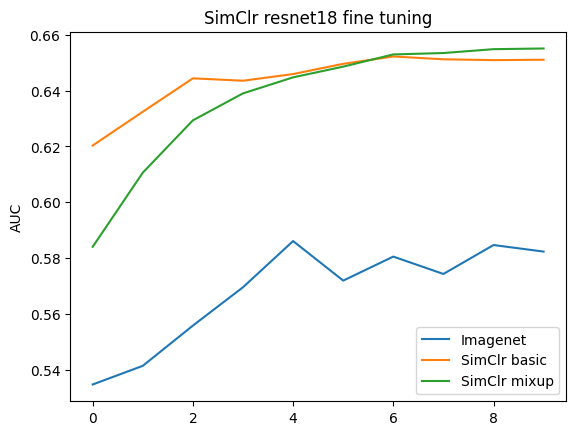

SimClr, r=0.01 saved_epoch=90 epochs=10 downsample=0.5
luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
luminal label values counts after resampling y
0    1739
1    1056
Name: count, dtype: int64
Running CV


auc,▁▃▄▅▇▇▇███
loss,▆█▆▄▄▃▃▂▂▁
max_auc,▁▃▄▅▇▇▇███
pf,▁▁▁▁▁▁▂▄▆█
auc,0.56772
loss,0.91822
max_auc,0.56772
pf,0.05767


luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
luminal label values counts after resampling y
0    1739
1    1056
Name: count, dtype: int64
Running CV


auc,▁▁▁▂▄▅▆▇▇█
loss,▆█▇▄▅▃▄▂▃▁
max_auc,▁▁▁▂▄▅▆▇▇█
pf,▁▁▁▁▁▁▁▂▂█
auc,0.56716
loss,0.91612
max_auc,0.56716
pf,0.00989


luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
luminal label values counts after resampling y
0    1739
1    1056
Name: count, dtype: int64
Running CV


auc,▁▂▃▁▃▄▆▆▅█
loss,▄█▇▃▄▂▃▂▂▁
max_auc,▁▂▃▁▃▄▆▆▅█
pf,▁▁▁▁▁▁▁▁▁▁
auc,0.55445
loss,0.92521
max_auc,0.55445
pf,0.0


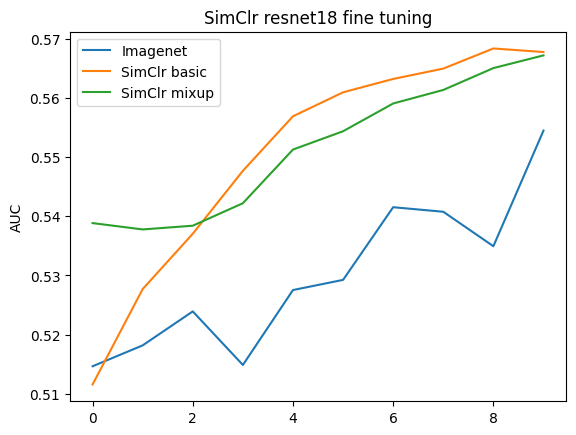

SimClr, r=0.01 saved_epoch=90 epochs=10 downsample=1.0
cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
Running CV


auc,▁▄▅▅▆▇▇▇██
loss,█▄▅▃▄▃▂▂▂▁
max_auc,▁▄▅▅▆▇▇▇██
pf,█████▇▇▁▃▂
auc,0.66099
loss,0.85645
max_auc,0.66099
pf,0.85461


cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
Running CV


auc,▁▄▆▆▇▇▇▇██
loss,█▅▅▃▄▃▂▂▂▁
max_auc,▁▄▆▆▇▇▇▇██
pf,███████▄▁▁
auc,0.66792
loss,0.84794
max_auc,0.66792
pf,0.85457


cancer pos_weight= 0.3392429324389075
Dataset number of images 5590 number of unique patients 1775
cancer label value counts y
1    4174
0    1416
Name: count, dtype: int64
Running CV


auc,▁▄▄▅▇▇▇█▇█
loss,█▄▄▃▃▂▃▁▂▁
max_auc,▁▄▄▅▇▇▇█▇█
pf,▁▁▁▁▁▁▁▁▁▁
auc,0.63601
loss,0.87028
max_auc,0.63601
pf,0.85513


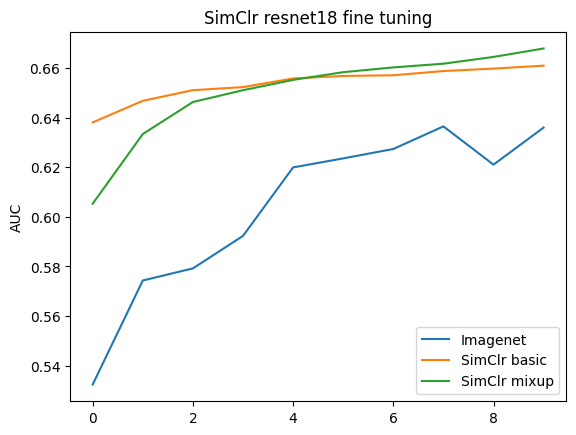

SimClr, r=0.01 saved_epoch=90 epochs=10 downsample=1.0
luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
Running CV


auc,▁▅▇███████
loss,█▇▅▅▄▄▁▂▃▃
max_auc,▁▅▇███████
pf,▁▁▁▂▃▄▅▇██
auc,0.56756
loss,0.92028
max_auc,0.56756
pf,0.09692


luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
Running CV


auc,▁▃▅▇▇▇▇███
loss,█▇▅▅▄▄▁▂▃▂
max_auc,▁▃▅▇▇▇▇███
pf,▁▁▁▁▁▂▂▄▆█
auc,0.57679
loss,0.91307
max_auc,0.57679
pf,0.08823


luminal pos_weight= 1.654320987654321
Dataset number of images 5590 number of unique patients 1775
luminal label value counts y
0    3484
1    2106
Name: count, dtype: int64
Running CV


auc,▁▃▄▅▅▇▆▇██
loss,██▅▆▅▅▁▃▄▄
max_auc,▁▃▄▅▅▇▆▇██
pf,▁▁▁▁▁▁▁▁▄█
auc,0.5493
loss,0.92767
max_auc,0.5493
pf,0.00366


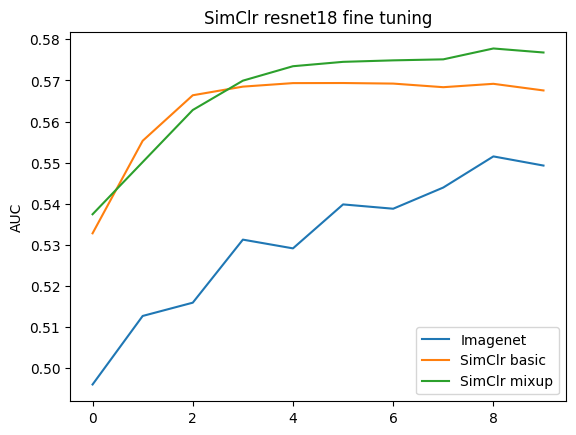

In [14]:

def run(path_basic, path_mixup, target, lr, epochs, cv, downsample, simclr):

    backbone_dim = 512 if MODEL_TYPE == "resnet18" else 2048

    auc_basic, pf1_basic, _ = finetune_model(lambda: load_model(MODEL_TYPE, False, False, simclr, path_basic).backbone, 
                                             target, backbone_dim, epochs, lr=lr, cv=cv, downsample=downsample, 
                                             weights_type="simclr_basic" if simclr else "simsiam_basic", 
                                             simclr=simclr)
    auc_mixup, pf1_mixup, _  = finetune_model(lambda: load_model(MODEL_TYPE, False, True, simclr, path_mixup).backbone, 
                                              target, backbone_dim, epochs, lr=lr, cv=cv, downsample=downsample, 
                                              weights_type="simclr_mixup" if simclr else "simsiam_mixup", 
                                              simclr=simclr)
    auc_none, pf1_none, _ = finetune_model(lambda: create_model(MODEL_TYPE, pretrained = True, num_classes = 0, drop_rate = 0., in_chans = 1), 
                                           target, backbone_dim, epochs, lr=lr, cv=cv, downsample=downsample, weights_type="imagenet", simclr=simclr)

    return auc_none, auc_basic, auc_mixup

cv = True
saved_epoch = 90
epochs = 10

# Evaluate for different lr, downsample rate and target label
for lr in [0.01]:
    for downsample in [0.5, 1.0]: #[1.0, 0.2]:
        for target in ['cancer', 'luminal']:

            # SimClr
            print(f"SimClr, r={lr} saved_epoch={saved_epoch} epochs=10 downsample={downsample}")
            auc_none, auc_basic, auc_mixup = run("checkpoints/model_simclr_resnet18_bs_160_epoch_90.pt", 
                                                 "checkpoints/model_simclr_resnet18_mixup_bs_160_epoch_90.pt", 
                                                 target=target, lr=lr, epochs = epochs, cv = cv, downsample=downsample, simclr = True)
            plot_finetunes([auc_none, auc_basic, auc_mixup], ['Imagenet', 'SimClr basic', 'SimClr mixup'], title = f"SimClr {MODEL_TYPE} fine tuning", y_label = "AUC")

            # SimSiam
            print(f"SimSiam Basic, r={lr} saved_epoch={saved_epoch} epochs=10 downsample={downsample}")
            auc_none, auc_basic, auc_mixup = run("checkpoints/model__resnet18_bs_160_epoch_90.pt", 
                                                 "checkpoints/model__resnet18_mixup_bs_160_epoch_90.pt", 
                                                 target=target, lr=lr, epochs = epochs, cv = cv, downsample=downsample, simclr = False)
            plot_finetunes([auc_none, auc_basic, auc_mixup], ['Imagenet', 'SimSiam basic', 'SimSiam mixup'], title = "SimSiam {MODEL_TYPE} fine tuning", y_label = "AUC")

